<a href="https://colab.research.google.com/github/CodeMonkey01/DataMiningI/blob/main/ANN_with_BERT_with_Stop_word_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with BERT
In this notebook I tried to solve the classification model with an ANN based on pretrained BERT layers.

## TODO:
- [ ] Stemming
- [x] Remove Stop Words

## Results
accuracy: 0.9211 - precision: 0.9406 - recall: 0.8988

Training time: 5 * 19 Minutes

## Model
Link to model: https://1drv.ms/u/s!AmxOqHLGuNXCmtNkCKCH0D7pggsJxQ?e=gF75Cx (hosted on OneDrive)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive
Sat May 14 11:33:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [ ]:
!pip install tensorflow_text
!pip install tensorflow_hub

     |████████████████████████████████| 4.9 MB 6.0 MB/s 
     |████████████████████████████████| 462 kB 26.3 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.txt')
df.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


# Check for imbalance
The dataset is equally balanced. Therefore, we do not need to rebalance the dataset.

In [ ]:
df["humor"].value_counts()

False    100000
True     100000
Name: humor, dtype: int64

# Preprocessing

In [ ]:
# Transform class from Boolean to integer value
df['class']=df['humor'].apply(lambda x: 1 if x==True else 0)

In [ ]:
# Remove stop words
from gensim.parsing.preprocessing import remove_stopwords

df['text']=df['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['class'], stratify=df['class'])

# BERT

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

## Test embedding
Test word embedding from pretrained BERT model with a real sentence from dataset.

In [ ]:
test_sentence = df["text"][100]
print("Test sentence:")
print(test_sentence)
print("Test sentence (word embedding):")
print(get_sentence_embeding([test_sentence]))

Test sentence:
The killer cookie-selling tactics history's brilliant girl scouts
Test sentence (word embedding):
tf.Tensor(
[[-0.83969486 -0.46593666 -0.7473084   0.6450492   0.40703234 -0.07280241
   0.7657241   0.32070833 -0.43726373 -0.99996203 -0.35160422  0.8527362
   0.98252136  0.2790011   0.893002   -0.3915408  -0.09077531 -0.54723877
   0.42776448 -0.21296531  0.62951225  0.999786    0.07549188  0.3833028
   0.47809762  0.9526682  -0.73260736  0.8940054   0.95125496  0.7634772
  -0.42085686  0.34979257 -0.9864075  -0.18078065 -0.77968717 -0.9924316
   0.4186119  -0.69977325  0.1565874   0.02758044 -0.8136708   0.3198204
   0.99978095  0.09387807  0.27348444 -0.2579574  -0.99999774  0.23344676
  -0.8186034   0.7064884   0.5501358   0.70959044  0.22955786  0.46321073
   0.4358194  -0.12789199 -0.06857965  0.13048996 -0.33727902 -0.56816155
  -0.65618753  0.48541984 -0.7217175  -0.8790387   0.7183341   0.51297957
  -0.2576277  -0.40635183 -0.16185673 -0.06262572  0.7847683   0.27

# Build model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
4688/4688 [==============================] - 1148s 242ms/step - loss: 0.2982 - accuracy: 0.8808 - precision: 0.8738 - recall: 0.8903
Epoch 2/5
4688/4688 [==============================] - 1129s 241ms/step - loss: 0.2485 - accuracy: 0.9017 - precision: 0.8977 - recall: 0.9067
Epoch 3/5
4688/4688 [==============================] - 1126s 240ms/step - loss: 0.2419 - accuracy: 0.9052 - precision: 0.9019 - recall: 0.9094
Epoch 4/5
4688/4688 [==============================] - 1119s 239ms/step - loss: 0.2376 - accuracy: 0.9066 - precision: 0.9033 - recall: 0.9108
Epoch 5/5
4688/4688 [==============================] - 1120s 239ms/step - loss: 0.2365 - accuracy: 0.9070 - precision: 0.9031 - recall: 0.9119


In [ ]:
model.evaluate(X_test, y_test)

1563/1563 [==============================] - 372s 238ms/step - loss: 0.2067 - accuracy: 0.9211 - precision: 0.9406 - recall: 0.8988


[0.206722691655159, 0.9210600256919861, 0.9406421184539795, 0.8988400101661682]

In [ ]:
model.save("/content/drive/MyDrive/Data Mining/stop words")

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[23582,  1418],
       [ 2529, 22471]])

Text(33.0, 0.5, 'Truth')

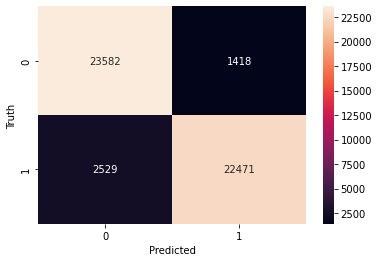

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     25000
           1       0.94      0.90      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000



# Own test

In [ ]:
jokes = [
    'What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I study Business Informatics at the University of Mannheim!',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them.',
    'My name is Elias.'
]
model.predict(jokes)

array([[0.7106663 ],
       [0.7403219 ],
       [0.81238645],
       [0.7502034 ],
       [0.95888543]], dtype=float32)

array([[0.7106663 ],
       [0.7403219 ],
       [0.81238645],
       [0.7502034 ],
       [0.95888543]], dtype=float32)